# 財報附註嚴重影響財務比率的判讀(2)：借款

財務報表分析的指標有許多面向

有的是評估獲利能力、經營狀況是否穩定，有的是評估財務狀況的健康度

財務比率中衡量公司財務體質的指標之一的「借款依存度」，就是計算：借款/股東權益

藉此評量一間公司營運所需資金中，來自借款與來自股東出資的比例

如下圖為南亞科(2408)的借款依存度計算：
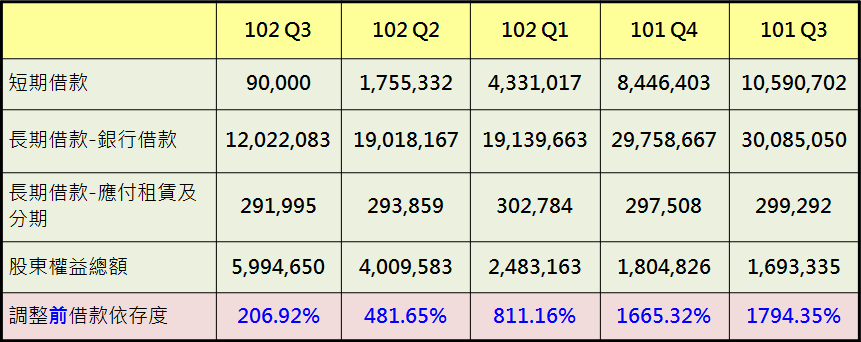

借款依存度就是把上表中所有借款相加後除以股東權益總額

我們可以看到南亞科的借款一存度逐年下降，到相當健康的206%(即借款是權益的兩倍)

是真的嗎？我們使用之前提過的查詢財務資料的程式把南亞科在2012~2013的財報查詢出來看看：

In [18]:
# %load merge_finance_price.py
"""
Created on Mon Jan 21 11:26:41 2019
本程式碼可以將季頻率的財報資料，按照財報揭露日，與每日的股價作時間軸的結合
@author: zyx
"""

import pandas as pd
import numpy as np
import tejapi  
tejapi.ApiConfig.api_key = "TEJAPIKEY"
class merge_finance_price_all(object):
    def __init__(self):
        self.merge_table = ''    
        self.table_kind_name = ''
        self.sampledates = [0,0]
        self.check_coid = [0]
    #查詢財報封面接露資料，內含財報公開日
    def do_query_only(self, table_kind,report_kind,check_coid,sampledates):
        output=None
        if table_kind =='TRAIL':
            acc_table = ['TRAIL/TAIM1AQA','TRAIL/TAIM1AQ','TRAIL/TAPRCD','TRAIL/TAIACC']
        else:
            acc_table = [table_kind+'/AIM1AQA',table_kind+'/AIM1AQ',table_kind+'/APRCD',table_kind+'/AIACC']
        if report_kind =='A':
            acc_table[0] = acc_table[0].replace("Q","")
            acc_table[1] = acc_table[1].replace("Q","")
        self.table_kind_name = acc_table[1]
        self.sampledates = sampledates
        self.check_coid = check_coid    
        #查詢財務科目代碼名稱對照表
        descript_data = tejapi.get(acc_table[3],opts={'columns':['code','cname','ename']}, paginate=True)            
        if len(check_coid)<1:
    #        a_data_coid = tejapi.get(acc_table[2],mdate={'gte':sampledates[0],'lte':sampledates[1]},opts={'columns':['coid']}, paginate=True)   
            acc_data_coid = tejapi.get(acc_table[0],mdate={'gte':sampledates[0],'lte':sampledates[1]},opts={"sort":"mdate.desc",'columns':['coid','mdate','a0003']}, paginate=True)
            check_coid = acc_data_coid['coid'].unique().tolist()
        for i in range(0,len(check_coid)):          
            announce_data = tejapi.get(acc_table[0], coid=check_coid[i],mdate={'gte':sampledates[0],'lte':sampledates[1]},opts={"sort":"mdate.desc",'columns':['coid','mdate','a0003']}, paginate=True)
            #查詢累計財報資料，可更換為非累積
            cumulative_data = tejapi.get(acc_table[1], coid=check_coid[i],mdate={'gte':sampledates[0],'lte':sampledates[1]},opts={"sort":"mdate.desc"}, paginate=True)
            if  len(announce_data)>0 and announce_data.loc[0,'a0003']is not None:                 
                data = announce_data
                
                all_col = cumulative_data['acc_code'].unique().tolist()
                all_date = sorted(cumulative_data['mdate'].unique()) #必須先排序，這樣才能確保從最舊的開始往新的填
                for new_col in all_col:
                    for a_date in all_date:        
                        this_val = cumulative_data.loc[(cumulative_data['acc_code']==new_col)&(cumulative_data['mdate']==a_date),'acc_value']
                        if len(this_val)>0:
                            data.loc[(data['mdate']==a_date),new_col]=this_val.values[0]
                change_name_list={}            
                for new_col in all_col:
                    col_name = descript_data.loc[descript_data['code']==new_col,'cname'].values[0]
                    change_name_list[new_col] = col_name    
                data = data.rename(change_name_list,axis='columns') 
                if output is None:
                    output = data
                else:
                    output = output.append(data, ignore_index=True)
    #            all_coid = output['coid'].unique().tolist()
    #            if len(all_coid)>5:
    #                break
        return output            

    def do_merge(self, table_kind,check_coid,sampledates,account_kind):            
        if table_kind =='TRAIL':
            acc_table = ['TRAIL/TAIM1AQA','TRAIL/TAIM1AQ','TRAIL/TAPRCD','TRAIL/TAIACC']
        else:
            acc_table = [table_kind+'/AIM1AQA',table_kind+'/AIM1AQ',table_kind+'/APRCD',table_kind+'/AIACC']
        sampledates = sampledates
        check_coid = check_coid   
   
        #print(acc_table)
        if len(check_coid)<1:
            #a_data_coid = tejapi.get(acc_table[2],mdate={'gte':sampledates[0],'lte':sampledates[1]},opts={'columns':['coid']}, paginate=True)   
            acc_data_coid = tejapi.get(acc_table[0],mdate={'gte':sampledates[0],'lte':sampledates[1]},opts={"sort":"mdate.asc",'columns':['coid','mdate','a0003','sem']}, paginate=True)
            check_coid = acc_data_coid['coid'].unique().tolist()
        ##查詢財報封面資料
        report_data = tejapi.get(acc_table[0], coid=check_coid,mdate={'gte':sampledates[0],'lte':sampledates[1]},opts={"sort":"mdate.asc",'columns':['coid','mdate','a0003','sem']}, paginate=True)
        #查詢財報科目名稱資料
        temp_code_data = tejapi.get(acc_table[3],opts={'columns':['code','cname','cgrp']})
        if len(account_kind)<1:
            code_data = temp_code_data
        else:
            for  i in range(0,len(account_kind)):
                if i ==0:
                    code_data = temp_code_data[temp_code_data['cgrp'].str.contains(account_kind[i])]
                else:
                    code_data = code_data.append(temp_code_data[temp_code_data['cgrp'].str.contains(account_kind[i])])
        query_code = code_data.drop_duplicates().values.tolist()
        #查詢財報資料
        #由於剛剛的操作fin_data已經被修改了，重查一次覆蓋掉原有結果
        fin_data = tejapi.get(acc_table[1],coid=check_coid,acc_code=query_code[0][0],mdate={'gte':sampledates[0],'lte':sampledates[1]},opts={'sort':'mdate.desc','columns':['mdate','coid','acc_value']}, paginate=True)
        #使用query_code裡面，代碼對應的名稱來作為rename()的參數
        fin_data = fin_data.rename({'acc_value':query_code[0][1]}, axis='columns')
        for i in range(1,len(query_code)):   #第0個元素剛剛已經查過，並作為最終輸出用的Dataframe了，不必再查
            fin_data_one_row = tejapi.get(acc_table[1],coid=check_coid,acc_code=query_code[i][0],mdate={'gte':sampledates[0],'lte':sampledates[1]},opts={'sort':'mdate.desc','columns':['mdate','coid','acc_value']}, paginate=True)
            if len(fin_data_one_row)>0:
                #使用query_code裡面，代碼對應的名稱來作為rename()的參數
                fin_data_one_row = fin_data_one_row.rename({'acc_value':query_code[i][1]}, axis='columns')
                fin_data = fin_data.merge(fin_data_one_row,on=['mdate','coid'],how='outer')
        
        this_announce_date = report_data.loc[report_data['coid']==check_coid[0],'a0003'].min().strftime('%Y-%m-%d')
        prc_data = tejapi.get(acc_table[2], coid=check_coid[0],mdate={'gte':this_announce_date,'lte':sampledates[1]},opts={"sort":"mdate.asc",'columns':['coid','mdate','close_d','roib']}, paginate=True)
        for i in range(1,len(check_coid)):
            this_announce_date = report_data.loc[report_data['coid']==check_coid[i],'a0003'].min().strftime('%Y-%m-%d')
            prc_data_temp = tejapi.get(acc_table[2], coid=check_coid[i],mdate={'gte':this_announce_date,'lte':sampledates[1]},opts={"sort":"mdate.asc",'columns':['coid','mdate','close_d','roib']}, paginate=True)
            prc_data = prc_data.append(prc_data_temp, ignore_index=True)
        report_data = report_data.rename({"a0003": "announceDate"}, axis='columns') 
        merge_fin_data = fin_data.merge(report_data,on=['mdate','coid'], how='left')
        merge_fin_data = merge_fin_data.rename({"mdate":"reportDate","announceDate":"mdate"}, axis='columns')
        prc_data = prc_data.merge(merge_fin_data,on=['mdate','coid'],how='left')
        prc_data = prc_data.sort_values(by=['coid','mdate'])
        prc_data = prc_data.fillna(method='ffill')
        return prc_data
    def do_output(self, data,dir_url):
        name = self.table_kind_name.replace('/','_')+'_'+self.sampledates[0]+'_'+self.sampledates[1]+'_'+str(len(self.check_coid))
#        dir_url = dir_url.replac
        data.to_csv(dir_url+'/'+name+'.csv',encoding ='big5')
#%%
temp_code_data = tejapi.get('TWN/AIACC',opts={'columns':['code','cname','cgrp']})
table_kind = 'TWN'
sampledates = ['2017-01-01','2019-01-01']   #要查詢的資料日期區間，必填
check_coid = ['2330']         #要查詢的股票代碼 ，可以輸入空值[]，則自動查詢全部代碼   
account_kind = ['損益表']        
##執行此function即可取得合併結果，執行時間需要1~2小時
mf = merge_finance_price_all()
##data = mf.do_query_only('TWN',check_coid,sampledates)
prc_data = mf.do_merge(table_kind,check_coid,sampledates,account_kind)
#dir_url = 'D://pywork'    #指定要儲存的路徑
#mf.do_output(data,dir_url)
eps = prc_data['每股盈餘'].unique().tolist()

In [19]:
#tejapi.ApiConfig.api_key = "你的API KEY"
sampledates = ['2011-01-01','2014-01-01']   #要查詢的資料日期區間，必填
check_coid = ['2408']                       #要查詢的股票代碼 ，可以輸入空值[]，則自動查詢全部代碼   
table_kind = 'TWN'                          #要查詢台灣財務資料庫
report_type = 'A'                                    #查詢非累積季報
mf = merge_finance_price_all()
data = mf.do_query_only(table_kind,report_type,check_coid,sampledates)

從查詢到的資料，我們直接看負債比率來驗證看看，借款依存度是否真的有戲劇般的下降：

In [20]:
data[['mdate','負債比率']]

,mdate,負債比率
None,,
0,2013-12-01 00:00:00+00:00,89.28
1,2013-09-01 00:00:00+00:00,93.61
2,2013-06-01 00:00:00+00:00,95.92
3,2013-03-01 00:00:00+00:00,97.38
4,2012-12-01 00:00:00+00:00,98.21
5,2012-09-01 00:00:00+00:00,98.34
6,2012-06-01 00:00:00+00:00,95.20
7,2012-03-01 00:00:00+00:00,89.02
8,2011-12-01 00:00:00+00:00,80.74


我們可以看到，負債比率雖然有所改善，但似乎沒有像借款依存度那樣戲劇性地大幅改善

這是因為財報上借款雖然下降了，但是負債並沒有下降！

而負債中存在一項巨額借款，財務報表的科目上並不歸類為借款：

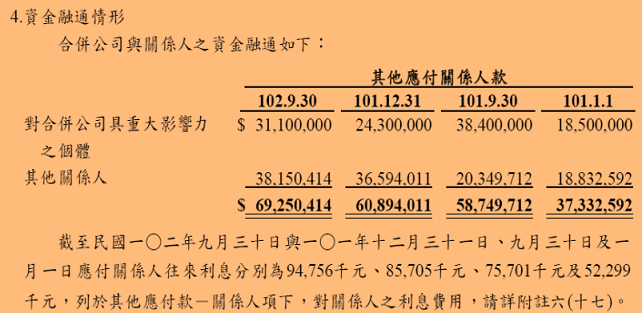


這個「具重大影響力」關係人借款就是台塑集團的本業：南亞、台塑化等公司

由於台塑集團的關係，每年借給南亞科鉅額借款，甚至比銀行借款高出數倍

這樣的資訊只會在財務報表附註事項揭露，若是無法深入解析財報附註

只看會計科目字面上的描述就會遺漏這筆需要負擔利息與借款義務的「其他應付款項」

因此若把這幾年的關係人其他應付款項加回，則借款依存度的計算結果就會變成：

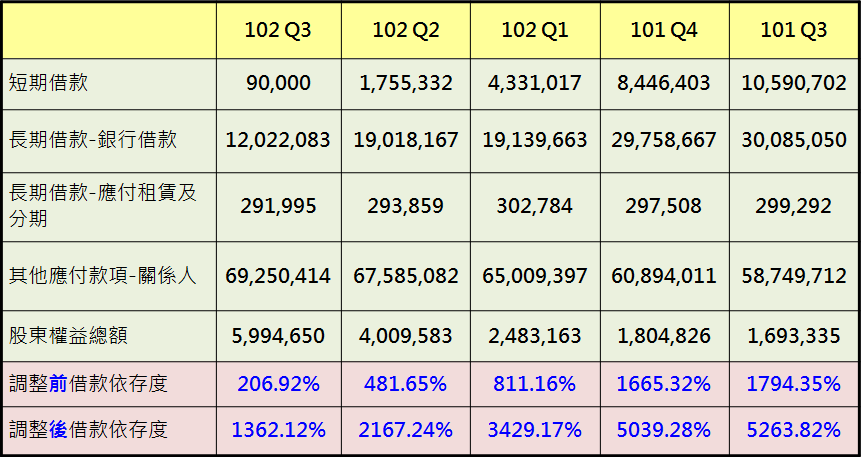

這麼一比就會發現，其實南亞科因為借款支應營運的負債狀況始終沒有改善

減少的借款幾乎都曾加到關係人其他應付款項上了

就算負債比例下降，靠的也是股東權益總額的上升，而不是真的改善了有著巨額借款的負債問題

最後，實際查詢TEJ API所提供的財務資料，可以看到借款依存度是調整過的，比原始值還要正確反應公司體質：

In [22]:
data[['mdate','借款依存度']]

,mdate,借款依存度
None,,
0,2013-12-01 00:00:00+00:00,774.28
1,2013-09-01 00:00:00+00:00,1362.24
2,2013-06-01 00:00:00+00:00,2167.41
3,2013-03-01 00:00:00+00:00,3429.45
4,2012-12-01 00:00:00+00:00,5039.66
5,2012-09-01 00:00:00+00:00,5264.22
6,2012-06-01 00:00:00+00:00,1733.67
7,2012-03-01 00:00:00+00:00,728.47
8,2011-12-01 00:00:00+00:00,366.14
